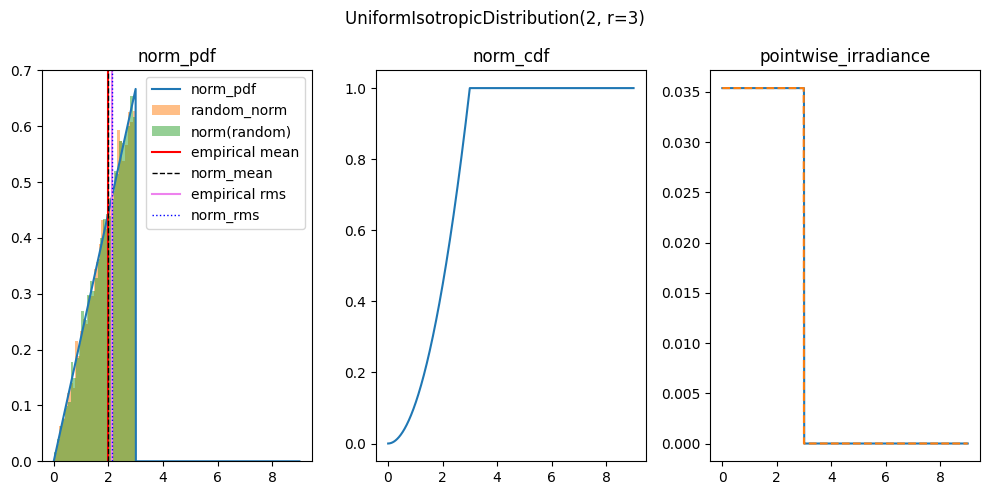

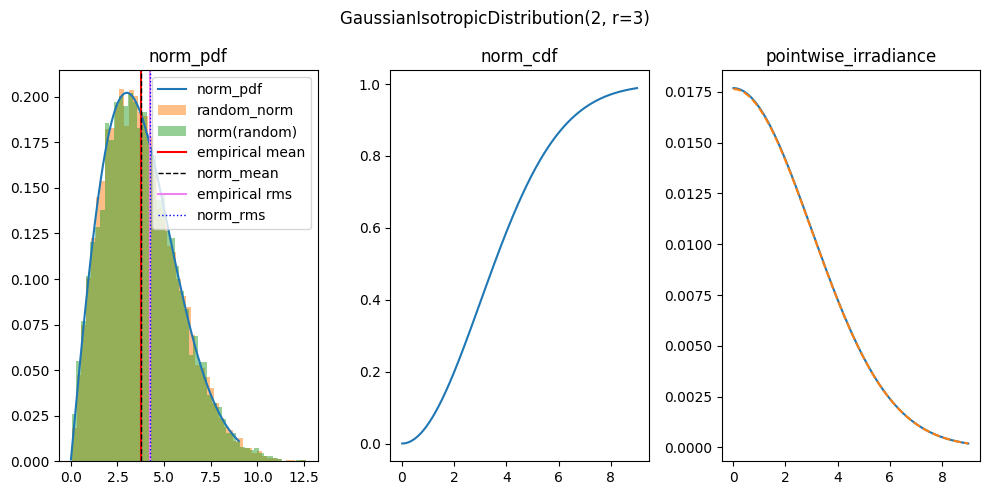

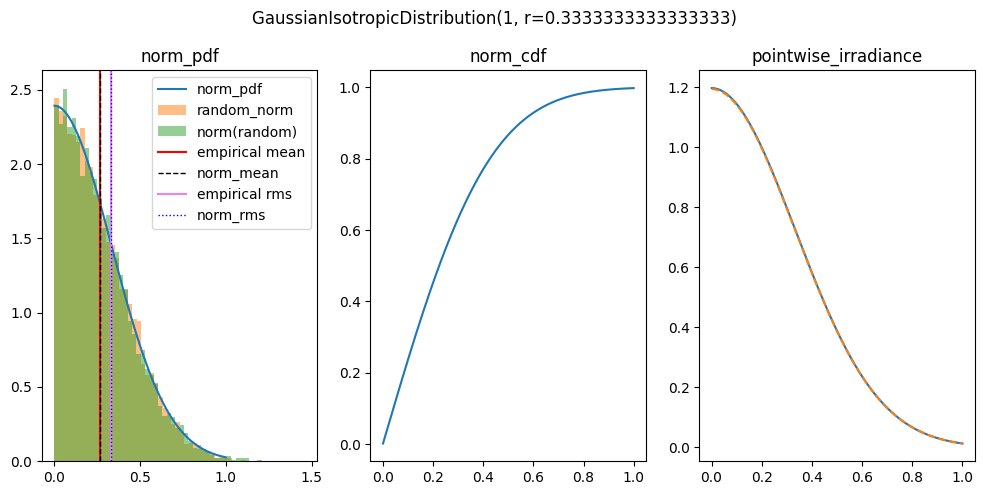

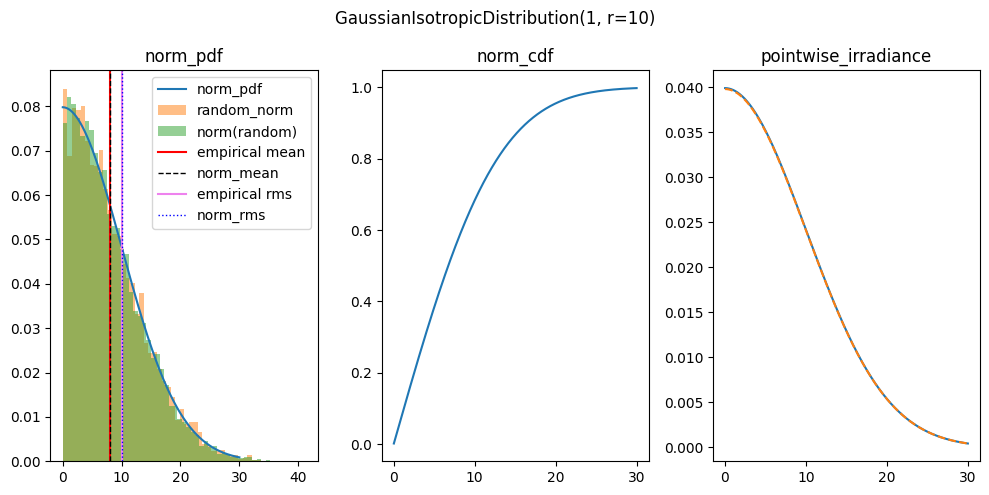

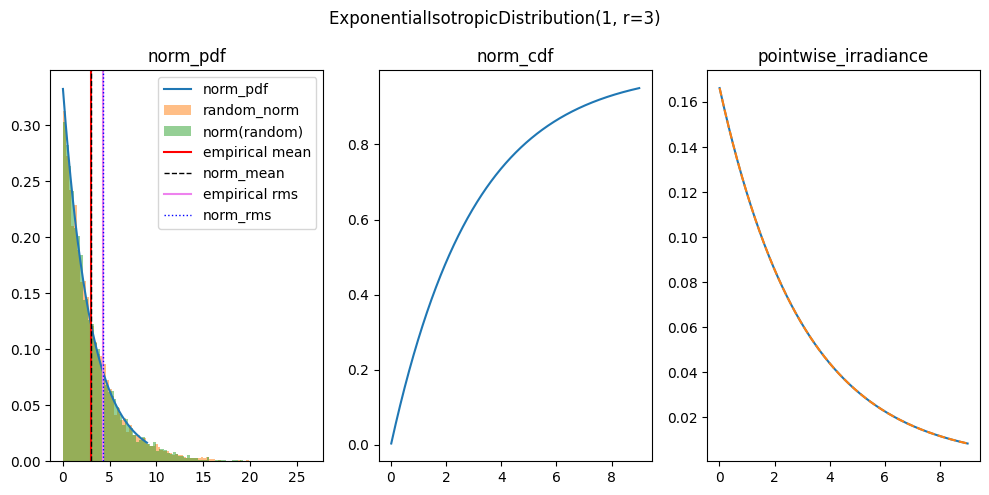

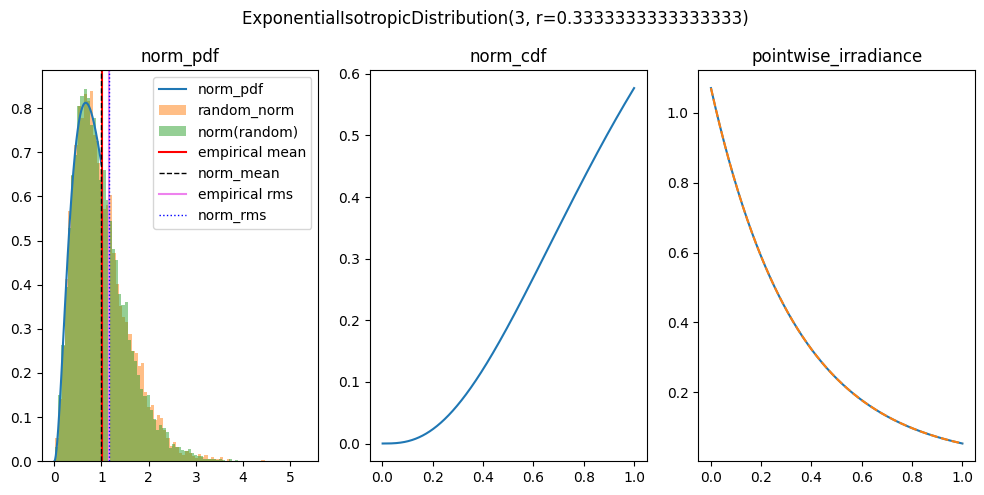

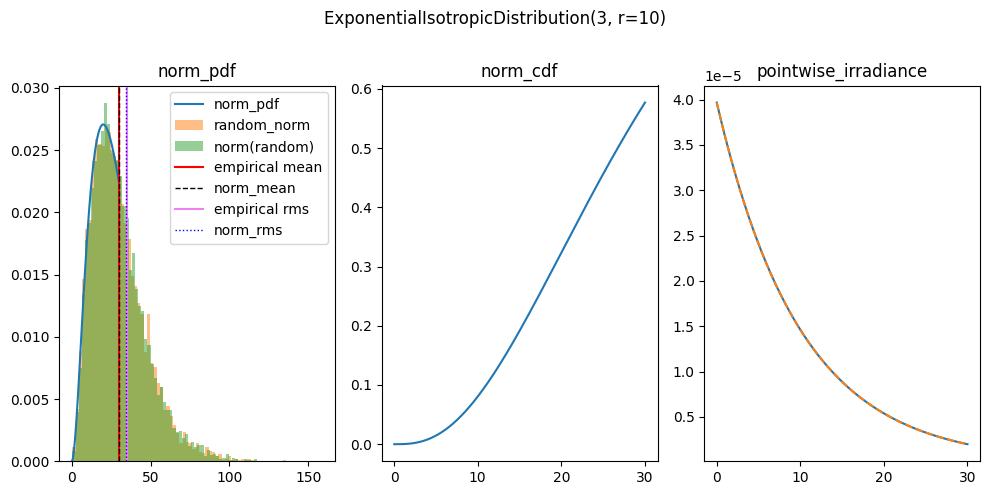

In [486]:

import abc
from typing import Any, cast
import numpy as np
import scipy.stats
import scipy.special
import matplotlib.pyplot as plt
import abc

class Hyperspheres(abc.ABC):
    '''
    norm_cdf and surface of the hyperspheres in R^d.

    Abstract class whose instances are either hard or fuzzy hyperspheres.
    By hard, we refer to a classical hypershpere ocupying a fixed norm_cdf.
    By fuzzy, we refer to an isotropic and unbounded distribution with
    fixed decay function.
    The fuzzy norm_cdf is the total weight of the fuzzy neighborhood
    '''
    
    _cache = {} # class attribute to cache instances
    def __new__(cls, d:int):
        key = (cls.__name__, d)
        obj = cls._cache.get(key)
        if obj is not None:
            return obj
        obj = super().__new__(cls)
        obj._init(d)
        cls._cache[key] = obj
        return obj
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self.d})"

    def _init(self, d:int): # if it was called __init__, it would be called even if cached 
        assert d==round(d) and d>=1, d
        self.d = d
        'Mass of a unit hypersphere in d dimensions with constant unit density'
        self._volume1 = np.pi**(d/2) / scipy.special.gamma(1 + d/2)
    
    def volume(self, r:float|np.ndarray):
        'volume of the hypersphere in d dimensions with radius r'
        return self._volume1 * r**self.d
    
    def surface(self, r:float|np.ndarray):
        'Surface of the hypersphere in d dimensions with radius r, i.e. (d_volume)/dr'
        return self.d * self._volume1 * r**(self.d-1)
    
    def random_on_surface(self, r:float|np.ndarray=1, size=None):
        'Draw uniformly from the sphere surface'
        r = np.asarray(r).astype(float)
        shape = r.shape if size is None else tuple(np.ravel(size))
        X =  np.random.normal(0, 1, size=(*shape, self.d))
        X /= r * np.linalg.norm(X, axis=-1, keepdims=True)
        return X
    

class IstotropicDistribution:
    '''
    The total mass is 1 = integral of norm_pdf(r) dr.
    The total volume is the integral of (norm_pdf(r) * space.surface(r)) dr.
    '''


    def __init__(self, d:int, r:float=1.0):
        assert d==round(d) and d>=1, d
        self.space = Hyperspheres(d)
        self.d = d
        self.r = r
        self._post_init()
    
    def _post_init(self):
        pass
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self.d}, r={self.r})"
    
    
    @abc.abstractmethod
    def norm_pdf(self, r:float|np.ndarray):
        'Density of |X| for X~self. (r>=0)'
        raise NotImplementedError
    
    def norm_cdf(self, r:float|np.ndarray):
        'probability mass that is enclosed in the hypersphere of radius r. (r>=0)'
        raise NotImplementedError
    
    def random(self, size=None):
        'Draw a sample from the distribution'
        X = self.space.random_on_surface(1, size=size)
        X *= self.random_norm(size)[...,None]
        return X
    
    @abc.abstractmethod
    def random_norm(self, size=None):
        raise NotImplementedError
    
    def pointwise_irradiance(self, r:float|np.ndarray):
        '''
        Equals norm_pdf(r) / space.surface(r)
        This is the "euclidean density" in the following sense:
        Fix any point x at radius r, let B(l) be the hypercube of side l centered at x.
        The pointwise_irradiance is the limit as l goes to 0 of the integral of the distribution
        over B(l) divided by the norm_cdf of l.
        '''
        r = np.where(r==0, 1e-10, r)
        return self.norm_pdf(r) / self.space.surface(r)

    def point_weights(self, X:np.ndarray, weights=None, filter_positive=False):
        'Weight each point x in X with its pointwise irradiance'
        # X, counts = np.unique(X, axis=0, return_counts=True)
        norms = np.linalg.norm(X, axis=-1)
        if weights is None:
            weights = np.ones_like(norms)
        weights = weights * self.pointwise_irradiance(norms)
        if filter_positive:
            X = X[weights>0]
            weights = weights[weights>0]
        return X, weights
    
    def _ref_irradiance(self, r:float|np.ndarray) -> float|np.ndarray:
        'Just for plotting purposes'
        raise NotImplementedError
    
# UniformIsotropicDistribution(3).test()


class ScipyIsotropicDistribution(IstotropicDistribution):
    _rv:scipy.stats.rv_continuous

    def random_norm(self, size=None):
        return self._rv.rvs(size) * self.r

    def norm_pdf(self, r:float|np.ndarray):
        'Density for the prob. that a point chosen uniformly from the hypersphere (norm_cdf) has radius r. (r>=0)'
        return self._rv.pdf(r/self.r) / self.r
    
    def norm_cdf(self, r:float|np.ndarray):
        return self._rv.cdf(r / self.r)

    def norm_rms(self):
        return (self.r**2 * self._rv.moment(2)) ** 0.5
    
    def norm_mean(self):
        return self._rv.moment(1) * self.r

cast_rv_continuous = lambda x: cast(scipy.stats.rv_continuous, x)

class UniformIsotropicDistribution(ScipyIsotropicDistribution):
    def _post_init(self):
        self._rv = cast_rv_continuous(scipy.stats.beta(self.d, 1))
    
    def _ref_irradiance(self, r:float|np.ndarray):
        return np.where(r<self.r, 1, 0) / self.space.volume(self.r)
    
    # Random_radius alternatives:
    # Formula 1: np.random.random(size)**(1/self.d) * self.r
    # Formula 2: np.max(np.random.random((*shape, d)), axis=1) * self.r


class GaussianIsotropicDistribution(ScipyIsotropicDistribution):

    def _post_init(self):
        self._rv = cast_rv_continuous(scipy.stats.chi(self.d))
    
    def random(self, size=None):
        shape = () if size is None else tuple(np.ravel(size))
        X =  np.random.normal(0, 1, size=(*shape, self.d))
        return X * self.r

    def _ref_irradiance(self, r:float|np.ndarray):
        rv = cast_rv_continuous(scipy.stats.halfnorm())
        c = 2**(self.d/2+1) / 5 * scipy.special.gamma(self.d/2)
        c *= self.space.surface(self.r)
        return rv.pdf(r/self.r)/self.r / c

class ExponentialIsotropicDistribution(ScipyIsotropicDistribution):

    def _post_init(self):
        self._rv = cast_rv_continuous(scipy.stats.gamma(self.d))

    def _ref_irradiance(self, r:float|np.ndarray):
        c = scipy.special.gamma(self.d) * self.space.surface(self.r)
        return 1/self.r * np.exp(-r / self.r) /c



def basic_plots(dist: IstotropicDistribution, rmax_factor:float=3, n=1000, n_samples=10000):
    rmax = dist.r * rmax_factor
    r = np.linspace(0, rmax, n)[1:]
    R = dist.random_norm(size=n_samples)
    R_method_2 = np.linalg.norm(dist.random(size=n_samples), axis=-1)
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].plot(r, dist.norm_pdf(r), label='norm_pdf')
    axes[0].hist(R, bins="auto", density=True, alpha=0.5, label='random_norm')
    axes[0].hist(R_method_2, bins="auto", density=True, alpha=0.5, label='norm(random)')
    axes[0].axvline(R.mean(), color='r',  label='empirical mean')
    if isinstance(dist, ScipyIsotropicDistribution):
        axes[0].axvline(dist.norm_mean(), color='black', lw=1, linestyle='--', label='norm_mean')
    
    axes[0].axvline(np.sqrt(np.mean(R**2)), color='violet',  label='empirical rms')
    if isinstance(dist, ScipyIsotropicDistribution):
        axes[0].axvline(dist.norm_rms(), color='blue', lw=1, linestyle=':', label='norm_rms')
    axes[0].legend()
    axes[0].set_title('norm_pdf')
    axes[1].plot(r, dist.norm_cdf(r))
    axes[1].set_title('norm_cdf')
    axes[2].plot(r, dist.pointwise_irradiance(r))
    axes[2].set_title('pointwise_irradiance')
    if hasattr(dist, '_ref_irradiance'):
        y = dist._ref_irradiance(r)
        axes[2].plot(r, y, linestyle='--') # type:ignore
    plt.suptitle(repr(dist))
    plt.tight_layout()
    plt.show()

# dist = UniformIsotropicDistribution(2, r=2)
# print(dist.norm_rms())
# dist = GaussianIsotropicDistribution(2, r=2)
# print(dist.norm_rms())

basic_plots(UniformIsotropicDistribution(2, r=3))
basic_plots(GaussianIsotropicDistribution(2, r=3))
basic_plots(GaussianIsotropicDistribution(1, r=1/3))
basic_plots(GaussianIsotropicDistribution(1, r=10))
basic_plots(ExponentialIsotropicDistribution(1, r=3))
basic_plots(ExponentialIsotropicDistribution(3, r=1/3))
basic_plots(ExponentialIsotropicDistribution(3, r=10))

